###### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

###### Data Reading

In [2]:
df = pd.read_csv("/content/MCD_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,34.29,34.29,33.20,33.52,9250100,MCD
2006-01-04,33.43,33.85,33.42,33.82,5990300,MCD
2006-01-05,33.82,34.20,33.73,33.86,6245200,MCD
2006-01-06,34.23,34.30,33.81,34.06,5877100,MCD
2006-01-09,34.00,34.74,33.99,34.71,4659900,MCD


###### Functions

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real McDonalds Stock Price')
    plt.plot(predicted, color='blue',label='Predicted McDonalds Stock Price')
    plt.title('McDonalds Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('McDonalds Stock Price')
    plt.legend()
    plt.show()

In [4]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

###### Exploratory Data Analysis

In [5]:
df.shape

(3020, 6)

In [6]:
df.isnull().sum()

Open      1
High      1
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [7]:
df['Open'].fillna(method='ffill',inplace=True,axis=0)
df['High'].fillna(method='ffill',inplace=True,axis=0)

In [8]:
training_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values

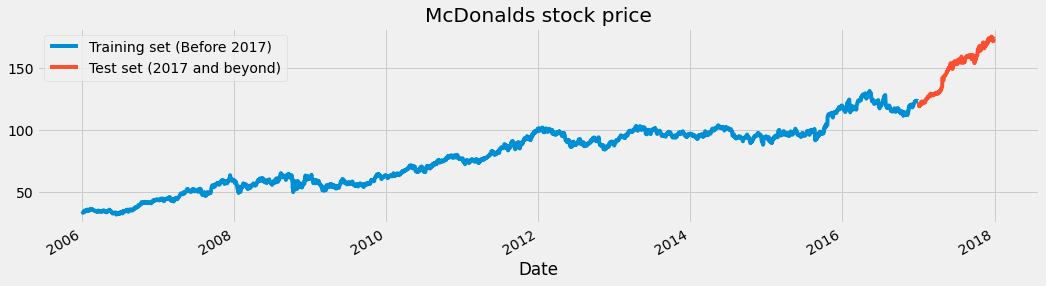

In [9]:
df["Open"][:'2016'].plot(figsize=(16,4),legend=True)
df["Open"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('McDonalds stock price')
plt.show()

In [10]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [11]:
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

##### Building LSTM Model -- Version 1

In [13]:
regressor1 = Sequential()
# First LSTM layer with Dropout regularisation
regressor1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor1.add(Dropout(0.2))
# Second LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.2))
# Third LSTM layer
regressor1.add(LSTM(units=50, return_sequences=True))
regressor1.add(Dropout(0.2))
# Fourth LSTM layer
regressor1.add(LSTM(units=50))
regressor1.add(Dropout(0.2))
# The output layer
regressor1.add(Dense(units=1))

In [14]:
regressor1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [15]:
regressor1.compile(optimizer='rmsprop',loss='mean_squared_error')

In [16]:
regressor1.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 15s 101ms/step - loss: 0.0175
Epoch 2/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0077
Epoch 3/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0065
Epoch 4/50
85/85 [==============================] - 9s 103ms/step - loss: 0.0053
Epoch 5/50
85/85 [==============================] - 9s 101ms/step - loss: 0.0048
Epoch 6/50
85/85 [==============================] - 9s 101ms/step - loss: 0.0040
Epoch 7/50
85/85 [==============================] - 9s 102ms/step - loss: 0.0037
Epoch 8/50
85/85 [==============================] - 9s 102ms/step - loss: 0.0034
Epoch 9/50
85/85 [==============================] - 8s 100ms/step - loss: 0.0034
Epoch 10/50
85/85 [==============================] - 9s 102ms/step - loss: 0.0030
Epoch 11/50
85/85 [==============================] - 9s 104ms/step - loss: 0.0028
Epoch 12/50
85/85 [==============================] - 9s 103ms/step - loss: 0.0028
Epoch 13/50
85/85 [=====

###### Test the model

In [17]:
dataset_total = pd.concat((df["Open"][:'2016'],df["Open"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [18]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor1.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 2s 26ms/step


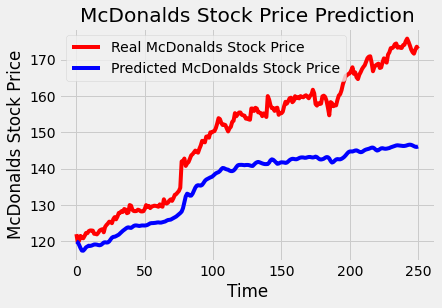

In [19]:
plot_predictions(test_set,predicted_stock_price)

In [20]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 15.437267543701273.


##### Building LSTM Model -- Version 2

In [21]:
regressor2 = Sequential()
# First LSTM layer with Dropout regularisation
regressor2.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor2.add(Dropout(0.2))
# Second LSTM layer
regressor2.add(LSTM(units=50, return_sequences=True))
regressor2.add(Dropout(0.2))
# Third LSTM layer
regressor2.add(LSTM(units=50, return_sequences=True))
regressor2.add(Dropout(0.2))
# Fourth LSTM layer
regressor2.add(LSTM(units=50))
regressor2.add(Dropout(0.2))
# The output layer
regressor2.add(Dense(units=1))

In [22]:
regressor2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [23]:
regressor2.compile(optimizer='rmsprop',loss='mean_squared_error')

In [24]:
regressor2.fit(X_train,y_train,epochs=50,batch_size=72)

Epoch 1/50
38/38 [==============================] - 11s 126ms/step - loss: 0.0391
Epoch 2/50
38/38 [==============================] - 5s 128ms/step - loss: 0.0141
Epoch 3/50
38/38 [==============================] - 5s 129ms/step - loss: 0.0110
Epoch 4/50
38/38 [==============================] - 5s 129ms/step - loss: 0.0085
Epoch 5/50
38/38 [==============================] - 5s 129ms/step - loss: 0.0087
Epoch 6/50
38/38 [==============================] - 5s 134ms/step - loss: 0.0063
Epoch 7/50
38/38 [==============================] - 5s 131ms/step - loss: 0.0060
Epoch 8/50
38/38 [==============================] - 5s 128ms/step - loss: 0.0061
Epoch 9/50
38/38 [==============================] - 5s 129ms/step - loss: 0.0052
Epoch 10/50
38/38 [==============================] - 5s 128ms/step - loss: 0.0051
Epoch 11/50
38/38 [==============================] - 5s 127ms/step - loss: 0.0046
Epoch 12/50
38/38 [==============================] - 5s 128ms/step - loss: 0.0042
Epoch 13/50
38/38 [=====

###### Test the model

In [25]:
dataset_total = pd.concat((df["Open"][:'2016'],df["Open"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [26]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price2 = regressor2.predict(X_test)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price2)

8/8 [==============================] - 2s 27ms/step


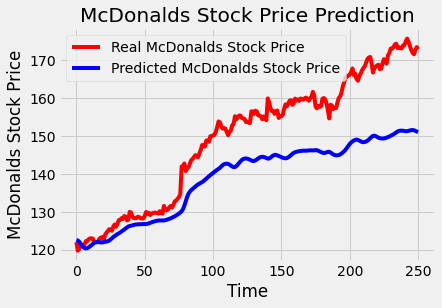

In [27]:
plot_predictions(test_set,predicted_stock_price2)

In [28]:
return_rmse(test_set,predicted_stock_price2)

The root mean squared error is 12.61755040246121.
